In [97]:
from sdv.demo import load_timeseries_demo
import pandas as pd

In [99]:
data = pd.read_csv('./AAPL Historical Data.csv')
data['Date'] =pd.to_datetime(data.Date)
data = data.sort_values(by='Date')
data.to_csv('new.csv')

TypeError: copy() takes from 1 to 2 positional arguments but 3 were given

In [67]:
data.head()

,Date,Price
0,2013-11-01,19.86
1,2013-12-01,20.04
2,2014-01-01,17.88
3,2014-02-01,18.79
4,2014-03-01,19.17


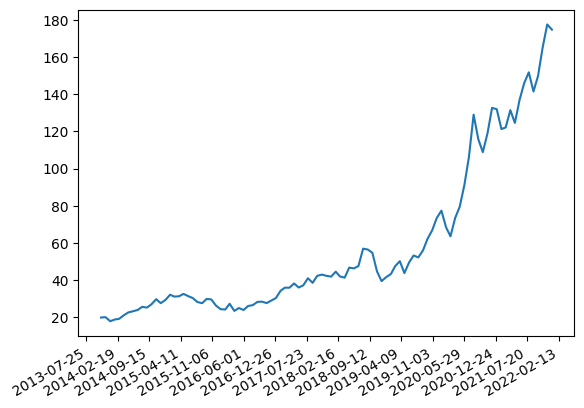

In [74]:
import matplotlib as plt
data = pd.read_csv('new.csv')
dates = list(data['Date'])
import datetime as dt
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = list(data['Price'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 5000))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()

In [75]:
from sdv.timeseries import PAR


In [92]:
model = PAR(
  )

In [94]:
model.fit(data)

In [96]:
data_new = model.sample(1)

KeyError: 'Symbol'

In [87]:
data_new = pd.DataFrame(data_new)

In [88]:
data_new['Date'] =pd.to_datetime(data_new.Date)
data_new = data_new.sort_values(by='Date')
data_new.to_csv('new.csv')

ValueError: Given date string a not likely a datetime present at position 0

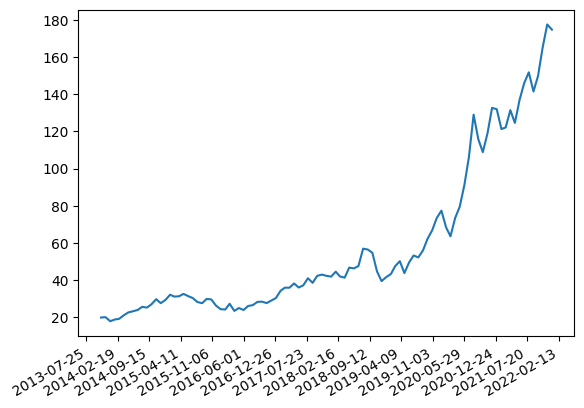

In [89]:
import matplotlib as plt
data_new = pd.read_csv('new.csv')
dates = list(data_new['Date'])
import datetime as dt
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = list(data_new['Price'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 5000))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()